In [1]:
import numpy as np
import os
import torch
import pandas as pd
import yaml

from sklearn.externals import joblib

from pytorch_utils.cfvae_models import CFVAEModel

In [2]:
outcome = 'los'
sensitive_variable = 'age'
data_path = 'data/'

# features_path = os.path.join(data_path, '{}_excluded'.format(sensitive_variable),'features')
features_path = os.path.join(data_path, 'features', str(0), '{}_excluded'.format(sensitive_variable))
label_path = os.path.join(data_path, 'labels')
# config_path = os.path.join(data_path, 'config', 'grid', 'baseline')
checkpoints_path = os.path.join(data_path, 'checkpoints', 'scratch', outcome)
performance_path = os.path.join(data_path, 'performance', 'scratch', outcome)

In [3]:
config_load_path = os.path.join(data_path, 'config', 'defaults', 'cfvae', outcome, sensitive_variable, 'model_config.yaml')
checkpoint_load_path = os.path.join(data_path, 'checkpoints', 'cfvae_default', outcome, sensitive_variable, str(1))
os.listdir(checkpoint_load_path)[0]

'1552683762.4261506.chk'

In [4]:
os.makedirs(checkpoints_path, exist_ok=True)
os.makedirs(performance_path, exist_ok=True)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
features_dict = joblib.load(os.path.join(features_path, 'features.pkl'))
master_label_dict = joblib.load(os.path.join(label_path, 'label_dict.pkl'))

In [7]:
data_dict = {split: features_dict[split]['features'] for split in features_dict.keys()}
label_dict = {split : master_label_dict[split][outcome] for split in master_label_dict.keys()}
group_dict = {split : master_label_dict[split][sensitive_variable] for split in master_label_dict.keys()}

In [8]:
group_map = pd.read_csv(os.path.join(label_path, '{}_map.csv'.format(sensitive_variable)))

In [9]:
# # with open(os.path.join(config_path, '{}.yaml'.format(grid_element)), 'r') as fp:
# #     config_dict = yaml.load(fp)
    
# CFVAE
# config_dict = {
#     # Standard parameters
#     'input_dim' : data_dict['train'].shape[1],
#     'num_groups' : len(np.unique(group_dict['train'])),
#     'lr' : 1e-3,
#     'lr_final_classifier' : 1e-3,
#     'gamma' : 0.99,
#     'num_epochs' : 10,
#     'iters_per_epoch' : 100,
#     'output_dim' : 2,
#     'batch_size' : 256,
#     'sparse' : True,
#     'sparse_mode' : 'binary',
#     # Parameters corresponding to the size of the VAE
#     'group_embed_dim' : 64,
#     'latent_dim' : 64,
#     'num_hidden' : 2,
#     'drop_prob' : 0.0,
#     'resnet' : False,
#     'normalize' : False,
#     # Parameters corresponding to the size of classifier
#     'hidden_dim_classifier' : 128,
#     'num_hidden_classifier' : 1,
#     'drop_prob_classifier' : 0.0,
#     'resnet_classifier' : False,
#     'normalize_classifier' : False,

#     # Lambda
#     'lambda_reconstruction' : 1e3,
#     'lambda_mmd' : 1e4,
#     'lambda_kl' : 0.0,
#     'lambda_classification' : 1e1,
#     'lambda_mmd_group' : 1e3
# }
with open(config_load_path, 'r') as fp:
    config_dict = yaml.load(fp)

In [10]:
config_dict

{'batch_size': 512,
 'drop_prob': 0.25,
 'drop_prob_classifier': 0.25,
 'gamma': None,
 'group_embed_dim': 64,
 'hidden_dim_classifier': 128,
 'input_dim': 368113,
 'iters_per_epoch': 100,
 'lambda_classification': 10.0,
 'lambda_kl': 0.0,
 'lambda_mmd': 10000.0,
 'lambda_mmd_group': 1000.0,
 'lambda_reconstruction': 1000.0,
 'latent_dim': 128,
 'lr': 0.0001,
 'lr_final_classifier': 0.001,
 'normalize': False,
 'normalize_classifier': True,
 'num_epochs': 20,
 'num_groups': 4,
 'num_hidden': 1,
 'num_hidden_classifier': 2,
 'output_dim': 2,
 'resnet': False,
 'resnet_classifier': False,
 'sparse': True,
 'sparse_mode': 'binary'}

In [11]:
config_dict_final_classifier = {
    'lr_final_classifier' : 1e-4,
    'lambda_final_classifier_cf' : 0e0,
    'lambda_clp' : 1e0,
    'lambda_clp_entropy' : 0e0,
    'num_epochs' : 10
#     'num_iters_per_epoch' : None,
    
}
# config_dict = {**config_dict, **config_dict_final_classifier}
config_dict.update(config_dict_final_classifier)

In [12]:
if sensitive_variable == 'gender':
    data_dict = {k: v[group_dict[k] < 2] for k,v in data_dict.items()}
    label_dict = {k: v[group_dict[k] < 2] for k,v in label_dict.items()}
    group_dict = {k: v[group_dict[k] < 2] for k,v in group_dict.items()}

In [13]:
model = CFVAEModel(config_dict)

In [14]:
model.load_weights(os.path.join(checkpoint_load_path, os.listdir(checkpoint_load_path)[0]))

In [15]:
result = model.train_final_classifier(data_dict, label_dict, group_dict)

Epoch 0/9
----------
Phase: train:
 loss: 1.986387, classification: 0.605021, classification_cf: 0.603095, clp: 1.381446, clp_entropy: 1.347702,
 auc: 0.658636, auprc: 0.297167, brier: 0.205970,
Phase: val:
 loss: 0.454992, classification: 0.435599, classification_cf: 0.396707, clp: 0.019329, clp_entropy: 1.123533,
 auc: 0.769257, auprc: 0.474205, brier: 0.137032,
Best model updated
Epoch 1/9
----------
Phase: train:
 loss: 1.097388, classification: 0.433313, classification_cf: 0.420559, clp: 0.663918, clp_entropy: 1.184365,
 auc: 0.788136, auprc: 0.494160, brier: 0.136640,
Phase: val:
 loss: 0.425890, classification: 0.417314, classification_cf: 0.377202, clp: 0.008584, clp_entropy: 1.054310,
 auc: 0.804684, auprc: 0.528150, brier: 0.130437,
Best model updated
Epoch 2/9
----------
Phase: train:
 loss: 0.805035, classification: 0.406040, classification_cf: 0.395548, clp: 0.399032, clp_entropy: 1.114293,
 auc: 0.828360, auprc: 0.570611, brier: 0.125784,
Phase: val:
 loss: 0.418900, clas

In [16]:
result_eval = model.predict_final_classifier(data_dict, label_dict, group_dict, phases = ['train', 'val', 'test'])
result_eval[1]

{'train': {'auc': [0.9243688882545661],
  'auprc': [0.7830637911711927],
  'brier': [0.09349408336677202],
  'loss': [0.3230186507105827],
  'classification': [0.3230186507105827]},
 'val': {'auc': [0.8321136830769613],
  'auprc': [0.5715110604958019],
  'brier': [0.12143113507111578],
  'loss': [0.39314546149510604],
  'classification': [0.39314546149510604]},
 'test': {'auc': [0.8306633389990918],
  'auprc': [0.5639516848896384],
  'brier': [0.11962883452094138],
  'loss': [0.38845229607362014],
  'classification': [0.38845229607362014]}}

In [17]:
result_eval_CLP = model.predict_final_classifier_CLP(data_dict, label_dict, group_dict, 
                                                     phases = ['val', 'test'])

In [18]:
cf_dict = result_eval_CLP[2]
cf_df = pd.concat({key: pd.DataFrame(cf_dict[key]) for key in cf_dict.keys()}).rename_axis(index = ['phase', 'id']).reset_index(0)

In [20]:
cf_df.head()

,phase,y,y_cf,group,group_cf,pred_prob_factual,pred_prob_cf,output_factual,output_cf
id,,,,,,,,,
0,test,0,0,3,0,0.119209,0.122946,-0.965626,-0.948741
1,test,0,0,3,0,0.102165,0.101832,-1.062975,-1.063432
2,test,0,0,2,0,0.098914,0.099946,-1.113395,-1.113574
3,test,0,0,2,0,0.225938,0.216460,-0.664886,-0.674541
4,test,1,1,2,0,0.651480,0.647351,0.309436,0.302300


In [24]:
cf_df = cf_df.assign(pred_diff = lambda x: x.pred_prob_cf - x.pred_prob_factual)
cf_df.head()

,phase,y,y_cf,group,group_cf,pred_prob_factual,pred_prob_cf,output_factual,output_cf,pred_diff
id,,,,,,,,,,
0,test,0,0,3,0,0.119209,0.122946,-0.965626,-0.948741,0.003737
1,test,0,0,3,0,0.102165,0.101832,-1.062975,-1.063432,-0.000332
2,test,0,0,2,0,0.098914,0.099946,-1.113395,-1.113574,0.001032
3,test,0,0,2,0,0.225938,0.216460,-0.664886,-0.674541,-0.009478
4,test,1,1,2,0,0.651480,0.647351,0.309436,0.302300,-0.004129


In [44]:
result = cf_df.groupby(['phase', 'y', 'y_cf', 'group', 'group_cf'])[['pred_diff']].agg(np.mean)

In [45]:
result = result.reset_index()

In [70]:
import matplotlib.pyplot as plt

0 0


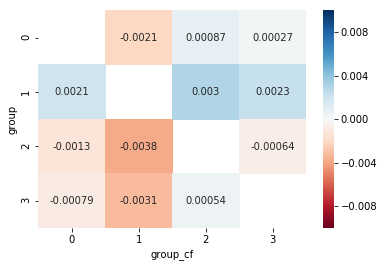

0 1


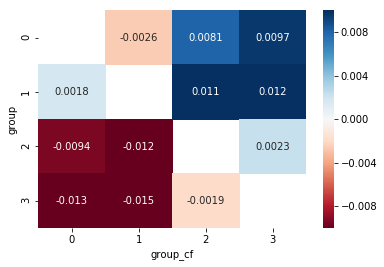

1 0


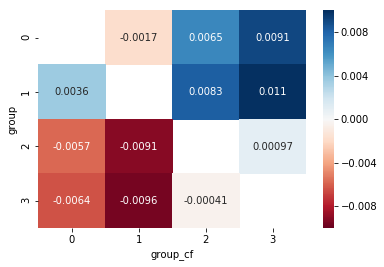

1 1


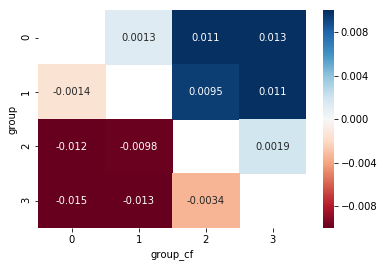

In [71]:
for y in [0, 1]:
    for y_cf in [0, 1]:
        print(y, y_cf)
        temp = result[(result.phase == 'val') & (result.y == y) & (result.y_cf == y_cf)]
        temp = temp.pivot('group', 'group_cf', 'pred_diff')
        ax = sns.heatmap(temp, annot = True, center = 0, cmap = 'RdBu', vmin = -0.01, vmax = 0.01)
        plt.show()

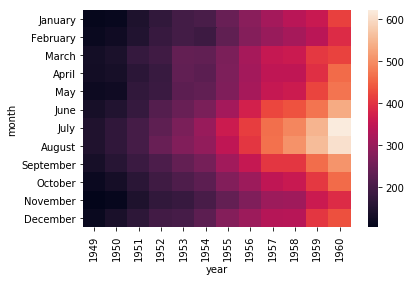

In [35]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)

In [36]:
flights

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419
April,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
June,135,149,178,218,243,264,315,374,422,435,472,535
July,148,170,199,230,264,302,364,413,465,491,548,622
August,148,170,199,242,272,293,347,405,467,505,559,606
September,136,158,184,209,237,259,312,355,404,404,463,508


In [43]:
result = result.reset_index()

,phase,y,y_cf,group,group_cf,pred_diff
0,test,0,0,0,1,-0.002136
1,test,0,0,0,2,0.000885
2,test,0,0,0,3,0.000452
3,test,0,0,1,0,0.002329
4,test,0,0,1,2,0.003062
5,test,0,0,1,3,0.002225
6,test,0,0,2,0,-0.001171
7,test,0,0,2,1,-0.003337
8,test,0,0,2,3,-0.000645
9,test,0,0,3,0,-0.000667


In [32]:
result['val']

y  y_cf  group  group_cf
0  0     0      1          -0.002074
                2           0.000866
                3           0.000266
         1      0           0.002052
                2           0.003028
                3           0.002335
         2      0          -0.001281
                1          -0.003808
                3          -0.000640
         3      0          -0.000787
                1          -0.003126
                2           0.000542
   1     0      1          -0.002553
                2           0.008113
                3           0.009668
         1      0           0.001767
                2           0.011111
                3           0.012374
         2      0          -0.009404
                1          -0.011553
                3           0.002328
         3      0          -0.012933
                1          -0.015118
                2          -0.001901
1  0     0      1          -0.001749
                2           0.006537
             